# Rare variants

This analysis aimed to answer the following research question: **What is the prevalence of rare variants within African populations, and do specific populations exhibit a higher rare variant burden?**

To answer this question, the following steps were performed: 

1. Data Generation: Genetic variation data was generated from genetic information obtained from the [GnomAD 1000 Genomes and HGDP datasets](https://gnomad.broadinstitute.org/news/2021-10-gnomad-v3-1-2-minor-release/) for African population groups.
2. Data Preparation: The generated genetic variation data was processed and prepared for analysis following the steps detailed in the `Notebooks\Data_preparation\2-IH_allele_counts.ipynb` Jupyter notebook. The resulting prepared data included variant positional information, allele counts, and frequencies, which are stored in the `Data\Processed\IH_allele_counts.csv` file. Additionally, metadata on the individuals from which genetic variation data was generated, was prepared and stored in the `Sample_populations.csv` file. 
3. Analysis and Visualisation: 
    * Variant allele frequencies were divided into quantiles.
    * Variant allele count and frequency data was grouped by frequency quantile and population group.
    * A bar plot showing the distribution of variants within the frequency bins for each population group was constructed.
    * The percentage of rare variants across all African populations was calculated, along with the specific count of rare variants within each individual African population group.

## Imports

Notebook setup

In [102]:
import os
import sys

from dotenv import load_dotenv

load_dotenv()

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
if PROJECT_ROOT not in sys.path:
    os.chdir(PROJECT_ROOT + "/Notebooks")
    sys.path.append(PROJECT_ROOT)

import numpy as np
import pandas as pd
import seaborn as sns
import upsetplot
from matplotlib import pyplot as plt
import Utils.constants as constants
import Utils.functions as functions

Import variant allele count data

In [103]:
ih_allele_counts = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "IH_allele_counts.csv",
    )
).drop(columns=["Unnamed: 0"])

ih_allele_counts.head(5)

,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,ID,CORR_IH_TOTAL_CTS,CORR_IH_REF_CTS,REG,CORR_IH_AF,VARIANT_TYPE
0,rs552586867,110148891,C,G,COL4A1,NaN,2,350,110148891_G_C,350,348,Recent African,0.005714,SNP
1,rs552586867,110148891,C,G,COL4A1,Yoruba,2,350,110148891_G_C,350,348,NaN,0.005714,SNP
2,rs59409892,110148917,C,G,COL4A1,Yoruba,40,392,110148917_G_C,392,352,NaN,0.102041,SNP
3,rs59409892,110148917,C,G,COL4A1,Mende,18,196,110148917_G_C,196,178,WA,0.091837,SNP
4,rs59409892,110148917,C,G,COL4A1,Bantu South Africa,2,16,110148917_G_C,16,14,SA,0.125000,SNP


## Analysis and visualisation

### Data grouping

Divide allele frequencies into quantiles

In [104]:
ih_allele_counts["QUANTILE"] = pd.cut(
    ih_allele_counts["CORR_IH_AF"],
    [0.0, 0.001, 0.005, 0.05, 0.5, 1.0],
    labels=[
        "< 0.001",
        "0.001-0.005",
        "0.005-0.05",
        "0.05-0.5",
        "> 0.5",
    ],
)
ih_allele_counts.head()

,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,ID,CORR_IH_TOTAL_CTS,CORR_IH_REF_CTS,REG,CORR_IH_AF,VARIANT_TYPE,QUANTILE
0,rs552586867,110148891,C,G,COL4A1,NaN,2,350,110148891_G_C,350,348,Recent African,0.005714,SNP,0.005-0.05
1,rs552586867,110148891,C,G,COL4A1,Yoruba,2,350,110148891_G_C,350,348,NaN,0.005714,SNP,0.005-0.05
2,rs59409892,110148917,C,G,COL4A1,Yoruba,40,392,110148917_G_C,392,352,NaN,0.102041,SNP,0.05-0.5
3,rs59409892,110148917,C,G,COL4A1,Mende,18,196,110148917_G_C,196,178,WA,0.091837,SNP,0.05-0.5
4,rs59409892,110148917,C,G,COL4A1,Bantu South Africa,2,16,110148917_G_C,16,14,SA,0.125000,SNP,0.05-0.5


#### Data selection

Select subpopulation (ethnolinguistic population group) allele frequency data

In [105]:
ih_afr_subpops = ih_allele_counts[
    ~((ih_allele_counts.REG == "Recent African") | (ih_allele_counts.REG == "African"))
]

#### Generate summary statistics for the variant frequencies. 
It is very important that the max allele frequency does not exceed 1. 

In [106]:
ih_afr_subpops["CORR_IH_AF"].describe()

count    42253.000000
mean         0.176864
std          0.238693
min          0.002841
25%          0.019231
50%          0.071429
75%          0.229730
max          1.000000
Name: CORR_IH_AF, dtype: float64

Verify the number of unique variants

In [107]:
ih_afr_subpops["ID"].nunique()

9678

#### Visualise the variant frequency distribution for each population group

Group data by frequency quantile and subpopulation

In [108]:
ih_afr_subpops_binned_grouped = (
    functions.group_and_count(
        data=ih_afr_subpops[["QUANTILE", "SUB_POP", "ID"]],
        group_columns=["QUANTILE", "SUB_POP"],
    )
    .reset_index()
    .rename(columns={"ID": "COUNT"})
)
ih_afr_subpops_binned_grouped.tail(5)

,QUANTILE,SUB_POP,COUNT
50,> 0.5,Mandinka,414
51,> 0.5,Mbuti Pygmy,482
52,> 0.5,Mende,396
53,> 0.5,San,409
54,> 0.5,Yoruba,408


Pivot data

In [109]:
# Pivot data before plotting

ih_afr_subpops_binned_pivot = ih_afr_subpops_binned_grouped.pivot(
    index="SUB_POP", columns="QUANTILE", values="COUNT"
)

ih_afr_subpops_binned_pivot

QUANTILE,< 0.001,0.001-0.005,0.005-0.05,0.05-0.5,> 0.5
SUB_POP,,,,,
Bantu Kenya,0,0,815,1554,406
Bantu South Africa,0,0,0,2154,377
Biaka Pygmy,0,0,1165,1862,428
Esan,0,581,1956,1829,415
Luhya,0,0,2904,1764,419
Mandenka,0,0,1086,1644,381
Mandinka,0,739,2245,1804,414
Mbuti Pygmy,0,0,785,1656,482
Mende,0,0,2571,1882,396


Set plot parameters

In [110]:
sns.set(rc={"figure.figsize": (10, 8)})  # set plot size

plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.MEDIUM_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

Generate a barplot to visualise variant frequency distribution for each gene

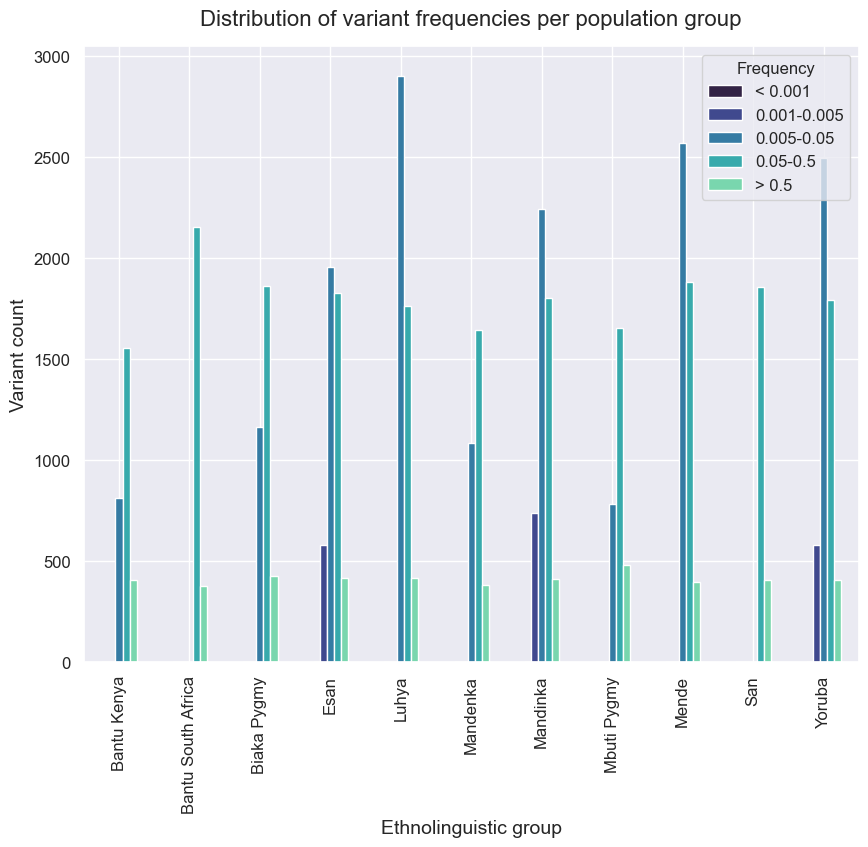

In [111]:
palette = sns.set_palette("mako", 5)

ih_afr_subpops_binned_pivot.plot.bar(logy=False, color=palette)

plt.xlabel("Ethnolinguistic group")

plt.ylabel("Variant count")

plt.legend(loc="upper right", frameon=True, title="Frequency")

plt.title(
    "Distribution of variant frequencies per population group",
    size=constants.LARGEST_FONT,
    pad=15,
)

plt.savefig("..\Results\Figures\Variant_frequencies.png", dpi=1200, bbox_inches="tight")

plt.show()

From the plot above, it is apparent that majority of the variants detected within each gene occurred at a low frequency of between 0.005 - 0.05 in the African population.

What percentage of variants found in all populations were rare, occuring at frequency below 0.005? African populations often contain higher amounts of rare variants compared to other global populations due to the incredible amount of genetic diversity in the African population.

In [112]:
rare_variants = ih_afr_subpops[ih_afr_subpops["CORR_IH_AF"] < 0.005]["ID"].nunique()
all_variants = ih_afr_subpops["ID"].nunique()

rare_variants

1783

In [113]:
rare_variant_percentage = (rare_variants / all_variants) * 100
rare_variant_percentage

18.423227939656954

Filter data for variants with rare frequencies

In [114]:
ih_afr_subpops_rare = ih_afr_subpops[ih_afr_subpops["CORR_IH_AF"] < 0.005]

In which subpopulations were rare variants found?

In [115]:
ih_afr_subpops_rare["SUB_POP"].unique()

array(['Esan', 'Yoruba', 'Mandinka'], dtype=object)

Get the count of rare variants for each subpopulation. To do this, group by subpopulation.

In [116]:
rare_count = ih_afr_subpops_rare[["SUB_POP", "ID"]].groupby("SUB_POP").count()
rare_count = rare_count.rename(columns={"ID": "RARE_COUNT"})

rare_count

,RARE_COUNT
SUB_POP,
Esan,581
Mandinka,739
Yoruba,579


All the rare variants seem to originate from three population groups, namely, the Yoruban group that was sampled by 1000 Genomes (note: some of the Yoruban samples came from the HGDP dataset), the Esan and Mandinka populations. Interestingly, these populations in which rare variants wer detected also the largest sample counts. It is possible that rare variants were detected in these variants that were not detected in other populations due to large sample counts.

Are any of the rare variants found in the populations, potentially novel? Variants will be classified as potentially novel if they do not have a [NCBI dbSNP rsID](https://customercare.23andme.com/hc/en-us/articles/212196908-What-Are-RS-Numbers-Rsid-#:~:text=The%20rsID%20number%20is%20a,convention%20used%20for%20most%20SNPs).

In [117]:
# Filter for rare variants without rsIDs

potential_novel_variants = ih_afr_subpops_rare[
    ~(ih_afr_subpops_rare.VAR_NAME.str.contains("rs"))
]

# Count the number of potentially novel, rare variants

potential_novel_variants["ID"].nunique()

654

What is the percentage novel variants of all rare variants

In [118]:
potential_novel_variants["ID"].nunique()/rare_variants

0.3667975322490185